In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import tensorflow
tensorflow.__version__

'2.1.0'

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
from zipfile import ZipFile
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation, ZeroPadding2D

#### Change current working directory to project folder

In [0]:
os.chdir('/content/drive/My Drive/Deep Learning/Face Recognition/')

### Extract the zip file
- Extract Aligned Face Dataset from Pinterest.zip

In [0]:
with ZipFile('Aligned Face Dataset from Pinterest.zip', 'r') as zip:
  zip.extractall()

### Function to load images
- Function to load the images from the extracted folder and map each image with person id 


In [0]:
class IdentityMetaData():
  def __init__(self, base, name, filename):
    self.base = base
    self.name = name
    self.filename = filename

  def __repr__(self):
    return self.image_path()

  def image_path(self):
    return os.path.join(self.base, self.filename, self.name)

In [0]:
def load_metadata(path):
  metadata = []
  for folder in os.listdir(path):
    for image in os.listdir(os.path.join(path,folder)):
      extension = os.path.splitext(image)[1]
      if(extension == '.jpg' or extension == '.jpeg'):
        metadata.append(IdentityMetaData(base=path, name=image, filename=folder))
  return np.array(metadata)

In [0]:
metadata = load_metadata('PINS')

### Define function to load image
- Define a function to load image from the metadata

In [0]:
def load_image(path):
  image = cv2.imread(path, cv2.IMREAD_COLOR)
  # OpenCV loads images with color channels
  # in BGR order. So we need to reverse them
  return image[...,::-1]

#### Load a sample image
- Load one image using the function "load_image"

Shape of image is (299, 299, 3)


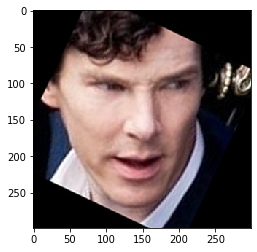

In [0]:
i = np.random.randint(1,500)
img_meta= metadata[i]
path = str(img_meta)
image = load_image(path)
plt.imshow(image)
print(f'Shape of image is {image.shape}')

In [0]:
image

array([[[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       ...,

       [[52, 32,  7],
        [52, 32,  7],
        [51, 34,  8],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 1,  0,  2]],

       [[52, 32,  7],
        [51, 31,  6],
        [50, 33,  7],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 1,  0,  2]],

       [[51, 31,  6],
        [51, 31,  6],
        [49, 32,  6],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 1,  0,  2]]], dtype=uint8)

### VGG Face model

In [0]:
def vgg_face():	
  model = Sequential()
  model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
  model.add(Convolution2D(64, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2,2), strides=(2,2)))
  
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(128, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(128, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2,2), strides=(2,2)))
  
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(256, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(256, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(256, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2,2), strides=(2,2)))
  
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(512, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(512, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(512, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2,2), strides=(2,2)))
  
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(512, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(512, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(512, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2,2), strides=(2,2)))
  
  model.add(Convolution2D(4096, (7, 7), activation='relu'))
  model.add(Dropout(0.5))
  model.add(Convolution2D(4096, (1, 1), activation='relu'))
  model.add(Dropout(0.5))
  model.add(Convolution2D(2622, (1, 1)))
  model.add(Flatten())
  model.add(Activation('softmax'))
  return model

#### Load the model
- Load the model defined above
- Then load the weights "vgg_face_weights.h5"

In [0]:
model = vgg_face()

In [0]:
model.load_weights('vgg_face_weights.h5')

### Get vgg_face_descriptor

In [0]:
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs = model.layers[0].input, outputs=model.layers[-2].output)

### Generate embeddings for all images (5 marks)
- Iterate through metadata and create embeddings for each image using `vgg_face_descriptor.predict()` and store in a list with name `embeddings`

- If there is any error in reading any image in the dataset, fill the emebdding vector of that image with 2622-zeroes as the final embedding from the model is of length 2622.

In [0]:
len(metadata)

10770

In [0]:
# Creating this function as a hack to avoid the memory error. Running the loop for 10700 records to generate the embededvector
# was causing a memory error, and the entire notebook had to be rerun again.

def create_embeddings(from_i=0, to_i=0, metadata=metadata):
  embeddings = []
  for meta in metadata[from_i:to_i]:
    try:
      image = load_image(str(meta))
      image = (image/255.).astype(np.float32)
      image = cv2.resize(image, (224,224))
      embeded_vector = vgg_face_descriptor.predict(np.expand_dims(image, axis=0))[0]
    except:
      embeded_vector = np.zeros(2622)
    finally:
      embeddings.append(embeded_vector)
  return embeddings

In [0]:
embeddings_1 = create_embeddings(from_i=0, to_i=4000)

In [0]:
embeddings_2 = create_embeddings(from_i=4000, to_i=5000)

In [0]:
embeddings_3 = create_embeddings(from_i=5000, to_i=7000)

In [0]:
embeddings_4 = create_embeddings(from_i=7000, to_i=10770)

In [0]:
embeddings = []
embeddings.extend(embeddings_1)
embeddings.extend(embeddings_2)
embeddings.extend(embeddings_3)
embeddings.extend(embeddings_4)

In [0]:
len(embeddings)

10770

### Create train and test sets

In [0]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0
test_idx = np.arange(metadata.shape[0]) % 9 == 0

In [0]:
X_train, X_test = np.array(embeddings)[train_idx], np.array(embeddings)[test_idx]

In [0]:
y_train, y_test = [obj.filename for obj in metadata[train_idx]] , [obj.filename for obj in metadata[test_idx]]

### Encode the Labels
- Encode the targets
- Use LabelEncoder

In [0]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

### Standardize the feature values
- Scale the features using StandardScaler

In [0]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Reduce dimensions using PCA
- Reduce feature dimensions using Principal Component Analysis

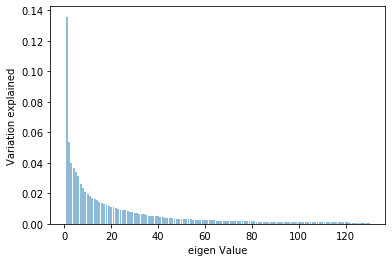

In [0]:
pca = PCA(n_components=130)
pca.fit(X_train_scaled)

plt.bar(list(range(1,131)),pca.explained_variance_ratio_,alpha=0.5, align='center')
plt.ylabel('Variation explained')
plt.xlabel('eigen Value')
plt.show()

In [0]:
X_pca_train = pca.transform(X_train_scaled)
X_pca_test = pca.transform(X_test_scaled)

### Build a Classifier 
- SVM Classifier to predict the person in the given image
- Fit the classifier and print the score

In [0]:
classifier = SVC(kernel='rbf')

In [0]:
classifier.fit(X_pca_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
y_pred = classifier.predict(X_pca_test)

(224, 224, 3)


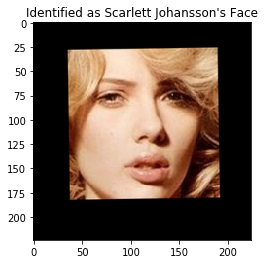

In [0]:
import warnings
warnings.filterwarnings('ignore')

example_idx = np.random.randint(0,1197)

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_image = (example_image/255.).astype(np.float32)
example_image = cv2.resize(example_image, (224,224))
print(example_image.shape)
embedding = vgg_face_descriptor.predict(np.expand_dims(example_image,axis=0))[0]
embedding_scaled = scaler.transform(embedding.reshape(1,-1))
example_prediction = classifier.predict(pca.transform(embedding_scaled))
example_identity = le.inverse_transform(example_prediction)[0].split('_')[-1]

plt.imshow(example_image)
plt.title(f"Identified as {example_identity}'s Face");